
# Détection de la santé des vignes à l'aide de SVM

## Contexte

Les maladies des vignes, telles que la "black measles" ou "black rot", peuvent affecter significativement la production de raisins. 
L'objectif de ce projet est de développer un modèle basé sur des machines à vecteurs de support (SVM) pour classifier automatiquement les images de vignes en fonction de leur état de santé : sain ou malade.

Ce notebook propose une approche détaillée incluant la préparation des données, une visualtisation, l'entraînement du modèle, et l'évaluation des performances.

### Étapes clés :
- Préparation des données : chargement, nettoyage et exploration des images.
- Construction d'un modèle de classification : entraînement d'un modèle supervisé.
- Évaluation des performances : visualisation et analyse des résultats.


---
## Préparation des données

Dans cette section, nous chargeons les images des vignes, redimensionnons celles-ci à une taille uniforme, et les divisons en ensembles d'entraînement et de test.

### Étapes :
- Charger les bibliothèques nécessaires.
- Définir le chemin des données et la taille des images.
- Charger les images et les étiquettes.


In [ ]:
from tqdm import tqdm
import pandas as pd 
import cv2
import os

path = 'C:/Users/mluporsi/OneDrive - inter-ges.com/Bureau/IA/deseases/Grape'
IMG_SIZE = 100

CATEGORIES = []
data = []

dirs = os.listdir(path)

# On récupère les catégories
for file in dirs:
    CATEGORIES.append(file)

# On récupère les images    
for category in tqdm(CATEGORIES):
    localPath = os.path.join(path, category)
    for img in os.listdir(localPath):
        img_array = cv2.imread(os.path.join(localPath, img))
        new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
        data.append([new_array, category])
        
df = pd.DataFrame(data, columns=['image', 'category'])
print(f'Le dossier contient {len(df)} images')

100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

Le dossier contient 1708 images


---
## Visualisation des images

Pour mieux comprendre nos images, nous affichons quelques exemples pour chaque catégorie. Cela permet de vérifier la diversité et la qualité des données.

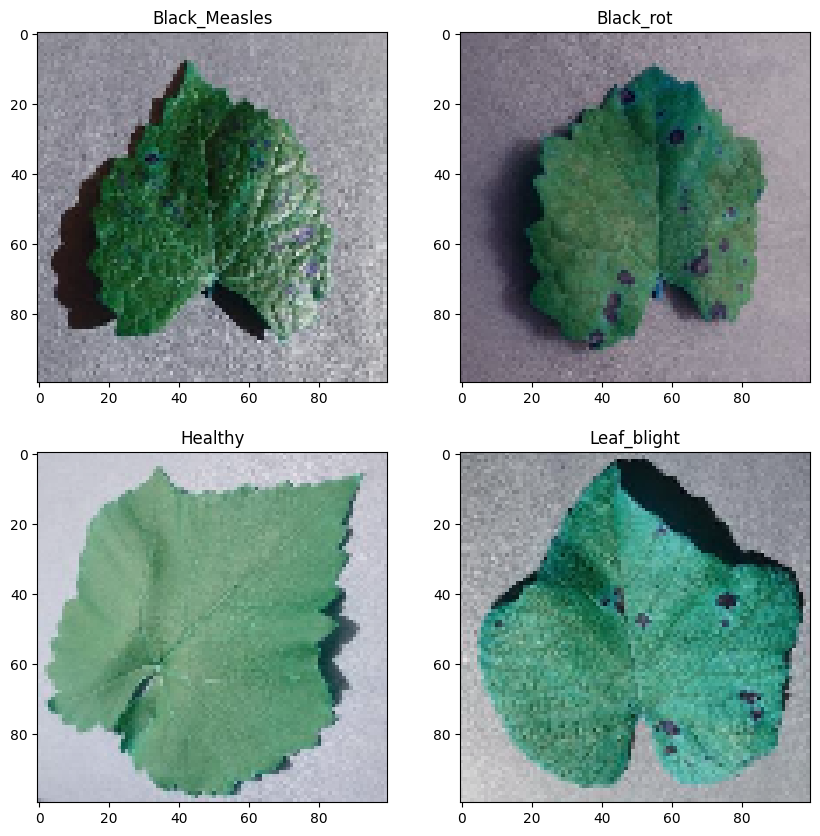

In [ ]:

import matplotlib.pyplot as plt

# On affiche une image de chaque catégorie
plt.figure(figsize=(10,10))
i = 1
for category in CATEGORIES:
    plt.subplot(2, 2, i)
    plt.imshow(df[df['category'] == category]['image'].iloc[0])
    plt.title(category)
    i += 1
plt.show()


---
## Préparation des données pour le modèle

Avant d'entraîner notre modèle, nous devons préparer nos données en :
- Divisant les données en ensembles d'entraînement et de test.
- Normalisant les données (valeurs entre 0 et 1).

Cela garantit que le modèle apprend efficacement et évite les biais liés à l'échelle des valeurs.

In [3]:
from sklearn.model_selection import train_test_split

X = df['image']
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
import numpy as np 

#flatten
X_train = X_train.values
X_test = X_test.values

X_train = np.array([i.flatten() for i in X_train])
X_test = np.array([i.flatten() for i in X_test])

# Normalisation des images
X_train = X_train/255
X_test = X_test/255


In [5]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (1366, 30000)
X_test shape: (342, 30000)



---
## Entraînement du modèle

Nous utilisons un SVM avec les paramètres suivants :
- **Kernel** : RBF (fonction de base radiale).
- **Gamma** : 0.001 (contrôle la portée de l'influence de chaque point d'entraînement).
- **C** : 10 (paramètre de régularisation).

L'entraînement se fait sur l'ensemble d'entraînement avec les étiquettes associées.

In [6]:

from sklearn.svm import SVC

# Définir et entraîner le modèle SVM
svc = SVC(kernel='rbf', gamma=0.001, C=10, class_weight='balanced')
svc.fit(X_train, y_train)


SVC(C=10, class_weight='balanced', gamma=0.001)


---
## Prédictions

Une fois le modèle entraîné, nous utilisons l'ensemble de test pour :
1. Générer des prédictions sur les images non vues.
2. Calculer la précision globale pour donner un aperçu initial des performances.

In [7]:
from sklearn.metrics import accuracy_score

# Génération des prédictions
pred = svc.predict(X_test)

# Calcul de la précision brute
accuracy = accuracy_score(y_test, pred)
print(f"Précision brute sur l'ensemble de test : {accuracy:.2f}")


Précision brute sur l'ensemble de test : 0.86



---
## Visualisation des performances

Pour évaluer les performances du modèle, nous utilisons une matrice de confusion graphique. Cette visualisation permet de mieux comprendre les erreurs de classification.

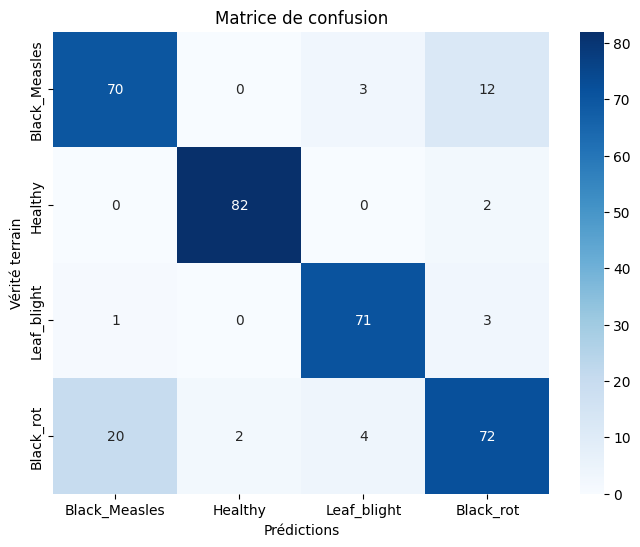

In [8]:

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Matrice de confusion graphique
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Prédictions")
    plt.ylabel("Vérité terrain")
    plt.title("Matrice de confusion")
    plt.show()

labels = list(set(y_test))  # Récupérer les catégories
plot_confusion_matrix(y_test, pred, labels)


Les catégories Healthy (82 prédictions correctes) et Leaf blight (71 prédictions correctes) sont bien reconnues par le modèle.

Cependant, il existe des confusions notables pour la catégorie Black Measles, où 20 images ont été mal classées comme Black rot.

Une amélioration pourrait être envisagée pour distinguer ces deux catégories similaires mais dans le contexte de notre projet ou on souhaite savoir si une vigne est saine, ces resultats sont satisfaisant au vu des resultats pour la catégorie healthy.


---
## Sauvegarde du model

Il est important de sauvegarder le model une fois qu'il nous convient pour pouvoir le réutiliser dans d'autres circonstances

In [10]:
# sauvegarde du modèle
import joblib

joblib.dump(svc, 'model.pkl')

['model.pkl']


---
## Conclusion

Le modèle développé dans ce notebook a permis d’atteindre une précision globale de 86 % sur la classification des vignes selon leur état de santé. Ce résultat est prometteur et montre que l’approche utilisée est efficace pour détecter certaines maladies des vignes à partir d’images. Cependant, l’analyse plus détaillée des résultats, via la matrice de confusion, révèle des forces et des faiblesses importantes.

En effet, certaines catégories, comme les vignes saines (Healthy) ou celles affectées par la Leaf blight, sont bien reconnues par le modèle. Cela démontre une capacité à différencier des états de santé visuellement distincts. Cependant, d’autres catégories, comme les Black Measles et le Black rot, présentent des confusions importantes, ce qui peut être dû à leur similarité visuelle ou à un manque de diversité dans les données d’entraînement.

Pour améliorer les performances du modèle, plusieurs pistes peuvent être envisagées :
- Augmenter la quantité et la diversité des données, notamment pour les catégories qui posent problème.
- Tester d’autres algorithmes ou architectures, comme des réseaux de neurones convolutionnels plus complexes.
- Optimiser les paramètres du modèle et explorer des techniques comme l’augmentation de données pour renforcer sa robustesse.

### Perspectives
- Le modèle pourrait être intégré dans un pipeline automatisé pour surveiller la santé des vignes en temps réel.
- En collectant plus de données et en améliorant le modèle, il pourrait servir comme un outil fiable pour les viticulteurs afin de détecter les maladies à un stade précoce.